In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

import numpy as np
import pandas as pd
import tensorflow as tf
from dataset_tools import df_to_dataset

from Tools.exp_tools import Experiment
from Tools.db_tools import DbManager
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from keras.models import load_model

In [3]:
exp_ids = ['NKIP_FA_052', 'NKIP_FA_053', 'NKIP_FA_055', 'NKIP_FA_056']
label_types = ['target','effector', 'dead_target', 'dead_effector']
experiments = [Experiment(exp_id) for exp_id in exp_ids]

master_df = (pd.concat([exp.db.get_annotations(label_type=label_types) for exp in experiments])
             .pivot(columns='label_type', index=['droplet_id', 'experiment_id', 'source'], values='value'))

In [4]:
manual_data = master_df.query('source == "manual"').copy().reset_index(level=2,drop=True)
manual_data = manual_data.loc[np.invert(manual_data.isna().any(axis=1))]
manual_data = manual_data.astype({'target': int, 'effector': int, 'dead_target': int, 'dead_effector': int})
manual_data.drop(index=manual_data.query('target == 10 | effector == 10 | dead_target == 10 | dead_effector == 10').index, inplace=True)
manual_data[manual_data > 4] = 4

In [13]:
import random
from functools import partial

def get_annotation_tables(annotations):
    annotations = annotations.copy()
    labels = annotations.columns.tolist()
    annotations['key'] = annotations.index.map(lambda idx: f"{idx[0]}|{idx[1]}")
    keys = tf.constant(annotations['key'].values)

    lookup_tables = {}

    for label in labels:
        values = tf.constant(annotations[label].values, dtype=tf.int64)

        table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(keys, values),
            default_value=-1
        )
        lookup_tables[label] = table
    return lookup_tables

def prepare_data(element, lookup_tables):

    # Build composite key
    key = tf.strings.join([tf.as_string(element['droplet_id']), element['experiment_id']], separator='|')

    # Prepare image
    image = tf.cast(element['frame'], tf.float32)
    image = tf.gather(image, indices=[0, 2, 3], axis=2)
    image.set_shape([128, 128, 3])
    image = tf.math.log(image + 1)
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))

    # Lookup and one-hot encode labels
    outputs = {}
    for label in lookup_tables:
        raw_label = lookup_tables[label].lookup(key)
        outputs[label + "_output"] = tf.one_hot(raw_label, 5, dtype=tf.int64)
    element['input_layer'] = image
    return element, outputs

def get_filter_table(indices):
    indices = indices.copy()
    keys = indices.map(lambda idx: f"{idx[0]}|{idx[1]}")
    values = tf.ones(len(keys), dtype=tf.int64)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys, values),
        default_value=-1
    )
    return table

def filter_dataset(element, lookup_table):
    key = tf.strings.join([tf.as_string(element['droplet_id']), element['experiment_id']], separator='|')
    val = lookup_table.lookup(key)
    return tf.not_equal(val, -1)

In [14]:
df = manual_data.copy()

tfrecord_files = []
for droplet_id, experiment_id in df.index:
    tfrecord_files.append(os.path.join(os.getenv('DB_DIR'), experiment_id, f'{droplet_id // 1024}.tfrecord'))
tfrecord_files = list(set(tfrecord_files))
random.shuffle(tfrecord_files)

ds = tf.data.TFRecordDataset(tfrecord_files, num_parallel_reads=5)
ds = ds.map(DbManager.parse_function)

## filtering
filter_table = get_filter_table(df.index)
ds = ds.filter(partial(filter_dataset, lookup_table=filter_table))

In [15]:
# adding annotations and preparing model input and output data
annotation_tables = get_annotation_tables(df)
ds = ds.map(partial(prepare_data, lookup_tables=annotation_tables))

In [16]:
model = load_model(os.path.join(os.getenv('MODEL_DIR'), 'cell_count_v4.keras'),compile=False)
predictions = model.predict(ds.batch(32))
y_pred = pd.DataFrame(np.argmax(np.array(predictions), axis=-1).transpose(), columns=label_types)

      1/Unknown 0s 472ms/step

2025-06-17 16:11:19.158600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


136/136 ━━━━━━━━━━━━━━━━━━━━ 33s 243ms/step


2025-06-17 16:11:52.144029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/fauberma/mambaforge/envs/phenotyping-gpu/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [17]:
rows = []
for i, (element, output) in enumerate(ds.as_numpy_iterator()):
    rows.append(np.array([np.argmax(output[f'{key}_output']) for key in label_types]))
y_true = pd.DataFrame(rows, columns=label_types)

2025-06-17 16:12:46.522802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0.5, 0, 'Predicted number of cells')

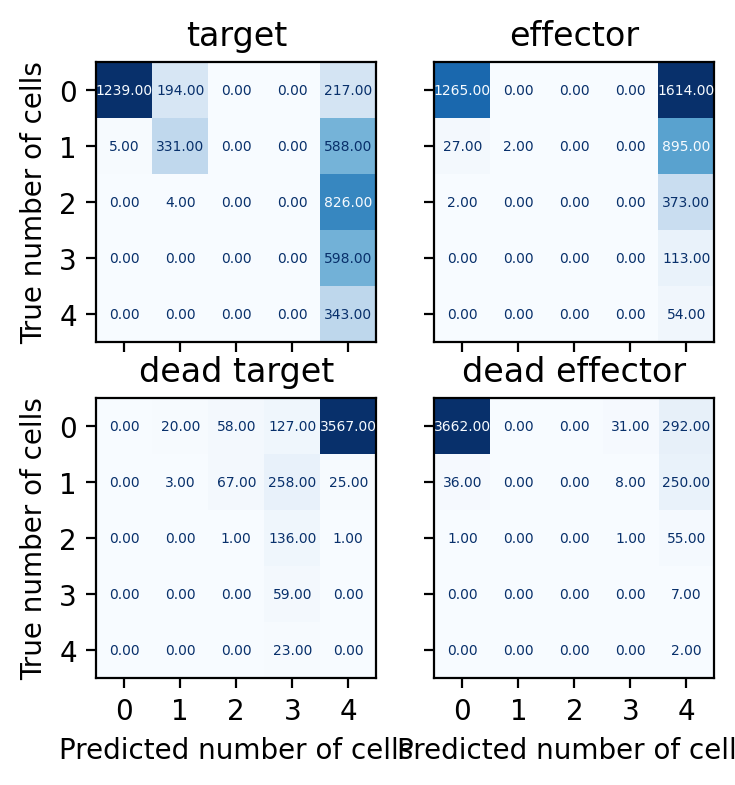

In [24]:
ann2title = {'target': 'target',
             'effector': 'effector',
             'dead_target': 'dead target',
             'dead_effector': 'dead effector'}

fig,axs = plt.subplots(ncols=2, nrows=2, figsize=(4,4), dpi=200, sharey=True, sharex=True)
for ax, ann in zip(axs.flatten(), label_types):
    ConfusionMatrixDisplay.from_predictions(y_true=y_true[ann], y_pred=y_pred[ann], labels=np.arange(5), normalize=None,
                                            cmap='Blues',ax=ax,colorbar=False, values_format='.2f', text_kw={'fontsize': 5})
    ax.grid(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(ann2title[ann])

axs.flatten()[0].set_ylabel('True number of cells')
axs.flatten()[2].set_ylabel('True number of cells')
axs.flatten()[2].set_xlabel('Predicted number of cells')
axs.flatten()[3].set_xlabel('Predicted number of cells')

In [38]:
get_annotation_tables(manual_data)

['dead_effector', 'dead_target', 'effector', 'target']


{'dead_effector': <tensorflow.python.ops.lookup_ops.StaticHashTable at 0x389f10390>,
 'dead_target': <tensorflow.python.ops.lookup_ops.StaticHashTable at 0x389f13dd0>,
 'effector': <tensorflow.python.ops.lookup_ops.StaticHashTable at 0x389effd50>,
 'target': <tensorflow.python.ops.lookup_ops.StaticHashTable at 0x389effa10>}

In [39]:
manual_data

,label_type,dead_effector,dead_target,effector,target
droplet_id,experiment_id,,,,
6,NKIP_FA_053,0,0,2,0
54,NKIP_FA_053,1,0,1,0
164,NKIP_FA_056,0,1,0,1
337,NKIP_FA_055,0,0,0,3
373,NKIP_FA_056,0,0,0,2
...,...,...,...,...,...
150074,NKIP_FA_053,0,0,1,1
150086,NKIP_FA_053,0,1,0,2
150124,NKIP_FA_053,0,1,0,1


In [26]:
tf.one_hot(-1,5)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>